# 📜 Visualiza dos dados entre videos do Youtube e os stocks de grandes empresas 📜 

## Importar Bibliotecas

In [10]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
from datetime import datetime
from functools import reduce
from pyspark.sql.functions import sum
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
#import matplotlib.cm as cm 
import matplotlib.pyplot as plt

## Criação do Spark para ser utilizado em PySpark

In [11]:
spark_ = SparkSession.builder \
    .appName("Data Integration") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

## Importanção dos dados das duas coleções já filtradas

In [ ]:
df_youtube = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.Youtube").load()

df_company = spark_.read.format("mongo") \
    .option("uri", "mongodb://mongodb:27017/Final_Database.Company").load()


In [17]:
companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']
countries = ['us', 'br', 'ca', 'fr', 'gb', 'in', 'kr', 'mx']

## Visualização dos dados em termos de Views por dia em cada empresa

/tmp/ipykernel_1075/1974055844.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


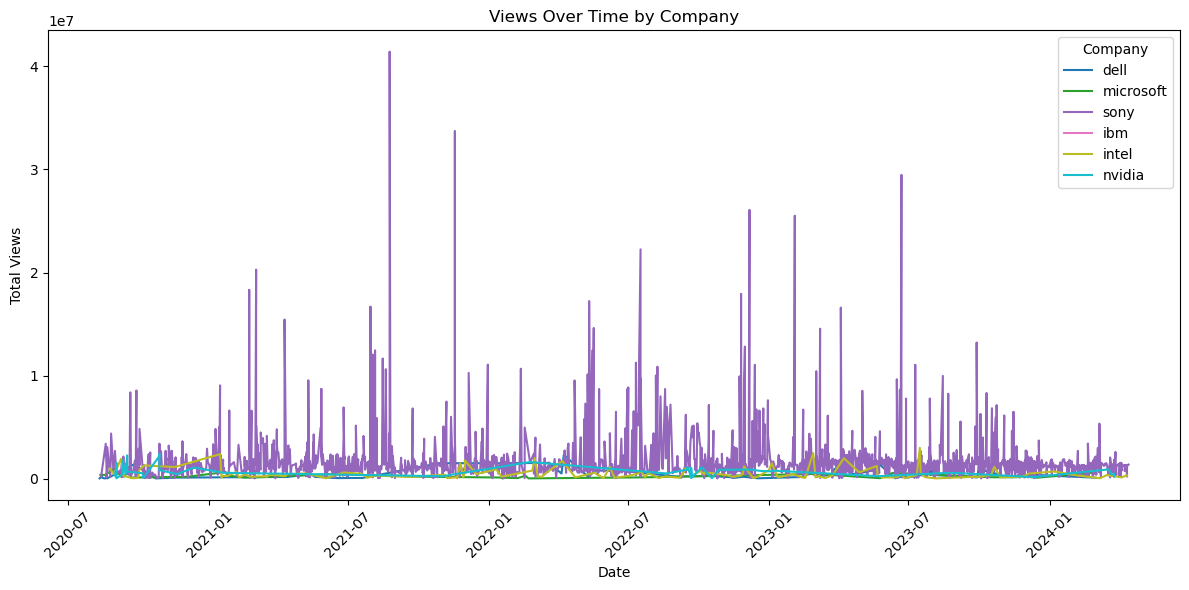

In [18]:
df_views_over_time = df_youtube.withColumn("published_date", to_date(col("publishedAt"))).groupBy(
    "published_date", "company", "title", "view_count"
).agg(
    sum("view_count").alias("total_views")
).orderBy("published_date")

colors = plt.cm.get_cmap('tab10', len(companies))
plot_data_yt = df_views_over_time.toPandas() 
plt.figure(figsize=(12, 6))
companies = plot_data_yt["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt[plot_data_yt["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
plot_data_yt = df_views_over_time.toPandas() 

In [21]:
plot_data_companies = df_company.toPandas()

/tmp/ipykernel_1075/1187951858.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


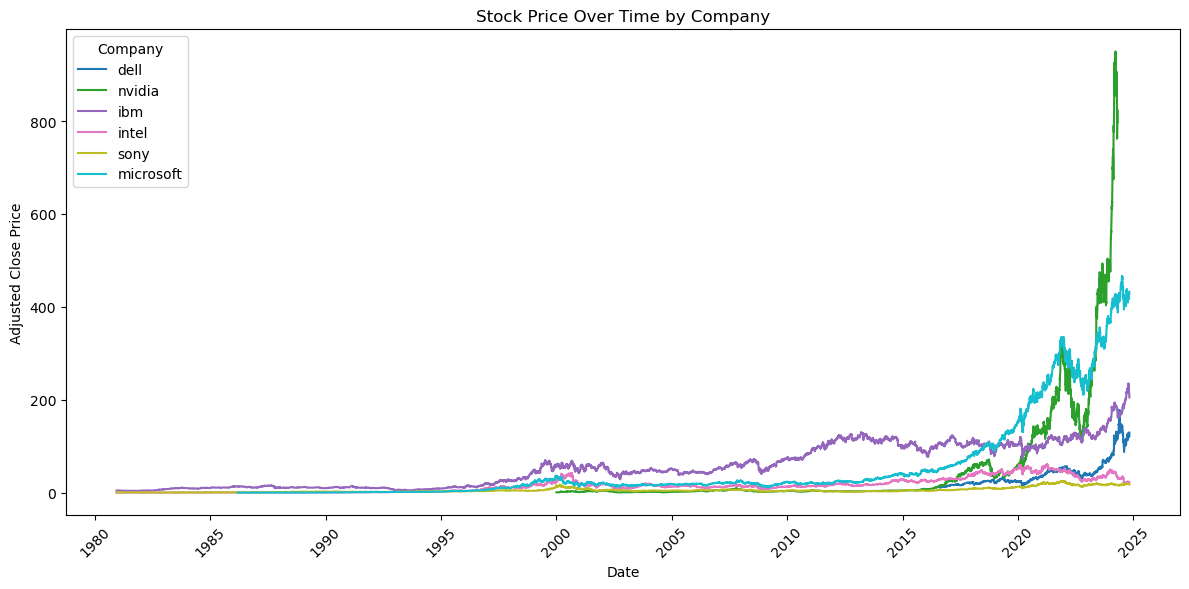

In [22]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))
for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1075/2948366094.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


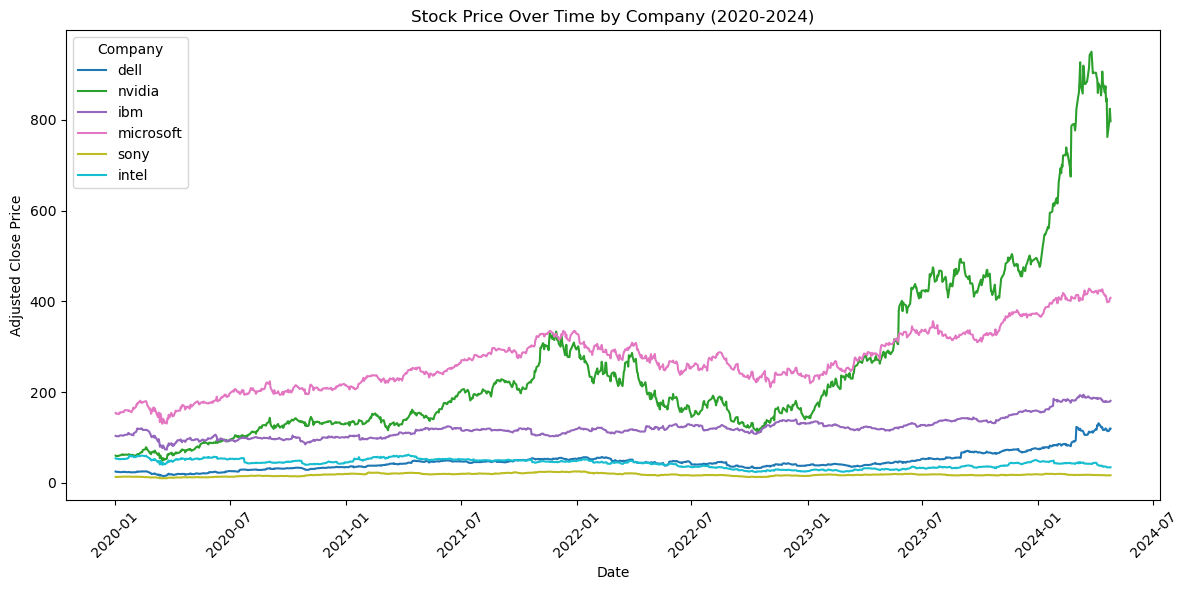

In [24]:
plot_data_filtered = df_company.filter(
    (col("Date") >= "2020-01-01") & (col("Date") <= "2024-04-24")
)

plot_data_companies = plot_data_filtered.toPandas()
plt.figure(figsize=(12, 6))
companies = plot_data_companies["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data_companies[plot_data_companies["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
plot_data_yt_company = plot_data_yt[
    (plot_data_yt["company"] != "ibm") &
    (plot_data_yt["company"] != "microsoft") &
    (plot_data_yt["company"] != "nvidia") &
    (plot_data_yt["company"] != "dell") &
    (plot_data_yt["company"] != "intel")
]


In [26]:
plot_data_yt_company

,published_date,company,title,view_count,total_views
2,2020-08-13,sony,Main Tumhara - Dil Bechara|Official Lyric Vide...,214441,214441
8,2020-08-19,sony,Ishq Kamaal – Sadak 2 | Javed Ali | Suniljeet-...,3385888,3385888
10,2020-08-20,sony,Doctor - Nenjame Music Video | Sivakarthikeyan...,1103512,1103512
11,2020-08-20,sony,Khulke Jeene Ka - Dil Bechara|Lyric Video|Sush...,104810,104810
12,2020-08-21,sony,Taarak Mehta Ka Ooltah Chashmah | तारक मेहता क...,1047961,1047961
...,...,...,...,...,...
2277,2024-04-10,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4055...,1327011,1327011
2279,2024-04-11,sony,घने जंगल में हुआ Team CID पर हमला | CID | Homi...,198132,198132
2280,2024-04-11,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4056...,1343002,1343002
2281,2024-04-12,sony,NEW! Taarak Mehta Ka Ooltah Chashmah | Ep 4057...,1286131,1286131


In [27]:
plot_data_companies_company = plot_data_companies[
    (plot_data_companies["company_name"] != "ibm") &
    (plot_data_companies["company_name"] != "microsoft") &
    (plot_data_companies["company_name"] != "nvidia") &
    (plot_data_companies["company_name"] != "dell") &
    (plot_data_companies["company_name"] != "intel")
]

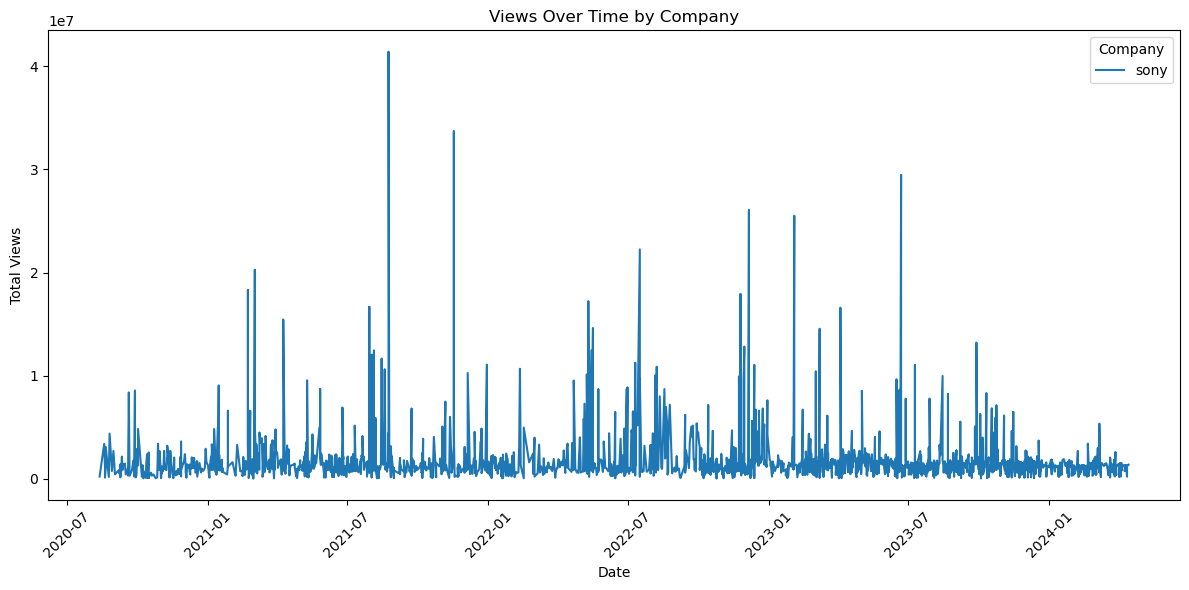

In [28]:
plt.figure(figsize=(12, 6))
companies = plot_data_yt_company["company"].unique()
for i, company in enumerate(companies):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["total_views"],
        label=company,
        color=colors(i)
    )
plt.title("Views Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1075/1549652962.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


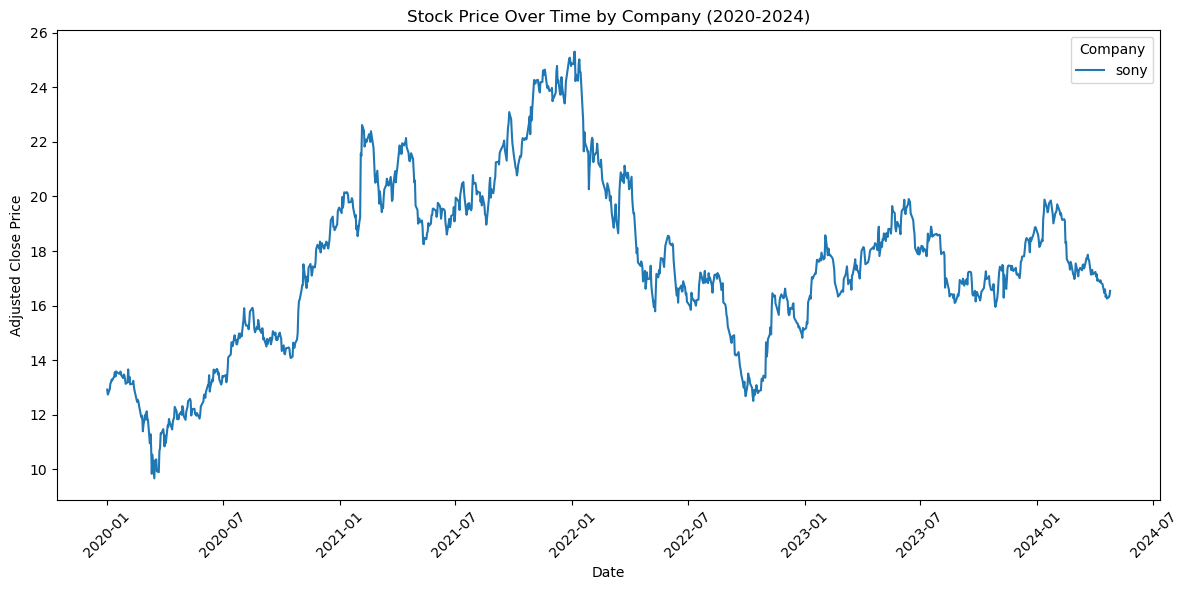

In [29]:
plt.figure(figsize=(12, 6))
companies = plot_data_companies_company["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))
for i, company in enumerate(companies):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))
plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())


/tmp/ipykernel_1075/1213189662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_yt_company["normalized_views"] = normalize(plot_data_yt_company["total_views"])
/tmp/ipykernel_1075/1213189662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_companies_company["normalized_stocks"] = normalize(plot_data_companies_company["Adj Close"])
/tmp/ipykernel_1075/1213189662.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor r

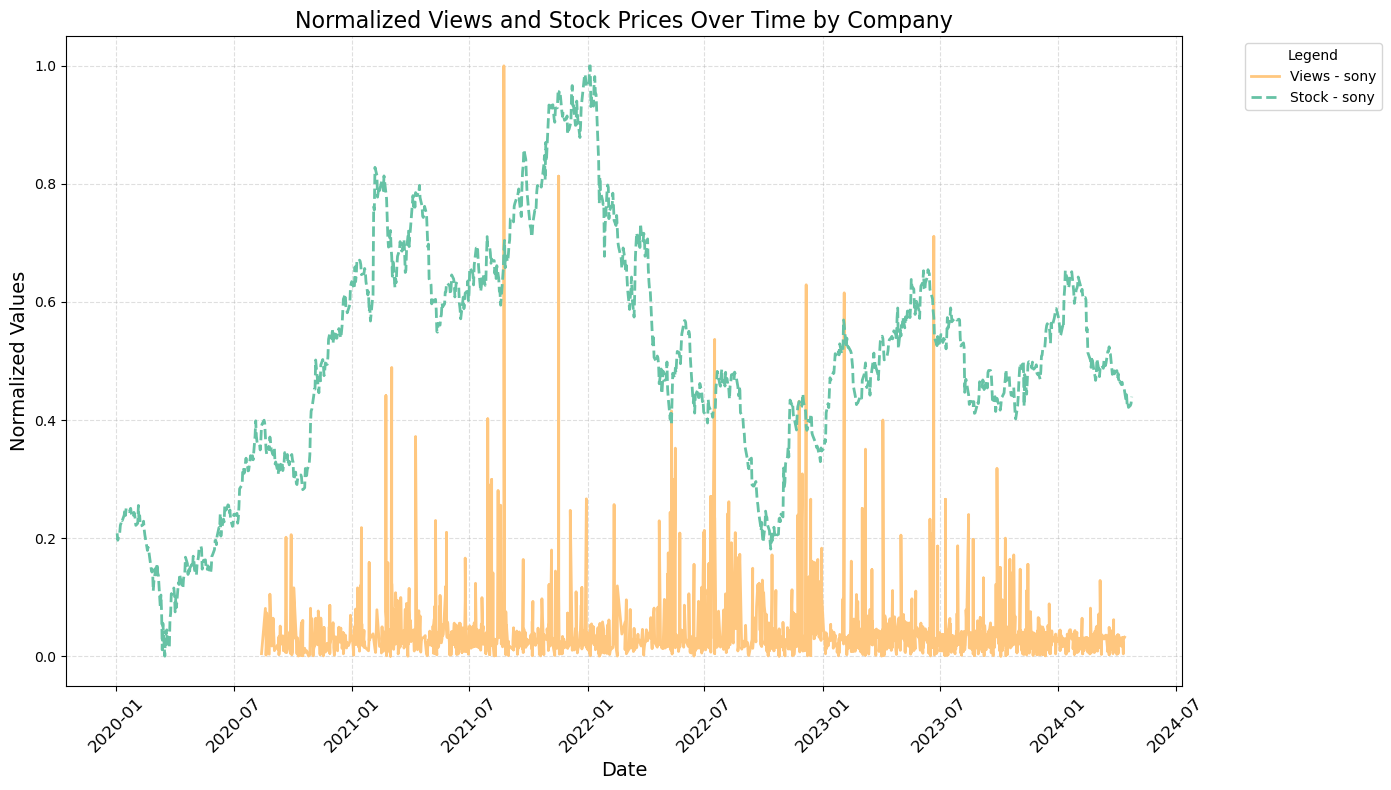

In [31]:
if 'published_date' not in plot_data_yt_company.columns:
    plot_data_yt_company['published_date'] = pd.to_datetime(plot_data_yt_company['published_date'], errors='coerce')


plot_data_yt_company["normalized_views"] = normalize(plot_data_yt_company["total_views"])
plot_data_companies_company["normalized_stocks"] = normalize(plot_data_companies_company["Adj Close"])

colors_views = cm.get_cmap('copper', len(plot_data_yt_company["company"].unique()))
colors_stocks = cm.get_cmap('Set2', len(plot_data_companies_company["company_name"].unique()))


plt.figure(figsize=(14, 8))
for i, company in enumerate(plot_data_yt_company["company"].unique()):
    company_data = plot_data_yt_company[plot_data_yt_company["company"] == company]
    plt.plot(
        company_data["published_date"],
        company_data["normalized_views"],
        label=f"Views - {company}",
        color=colors_views(i),
        linestyle='-',  
        linewidth=2
    )
for i, company in enumerate(plot_data_companies_company["company_name"].unique()):
    company_data = plot_data_companies_company[plot_data_companies_company["company_name"] == company]
    plt.plot(
        company_data["Date"],
        company_data["normalized_stocks"],
        label=f"Stock - {company}",
        color=colors_stocks(i),
        linestyle='--',  
        linewidth=2
    )
plt.title("Normalized Views and Stock Prices Over Time by Company", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Normalized Values", fontsize=14)
plt.legend(title="Legend", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

In [32]:
top_5_microsoft = plot_data_yt[plot_data_yt["company"] == "microsoft"].nlargest(5, "view_count")
top_5_nvidia = plot_data_yt[plot_data_yt["company"] == "nvidia"].nlargest(5, "view_count")

print("Top 5 vídeos da Microsoft:")
print(top_5_microsoft[["title", "view_count", "published_date"]])
print("\nTop 5 vídeos da NVIDIA:")
print(top_5_nvidia[["title", "view_count", "published_date"]])

Top 5 vídeos da Microsoft:
                                                 title  view_count  \
20                 Microsoft Surface Duo Unboxing. Wow     1023918   
49   Microsoft Duo Durability Test! - How Thin is t...      999171   
833        How Microsoft buys out every gaming company      803071   
492  Windows 11: Microsoft CEO Satya Nadella on the...      698557   
240         Microsoft Surface Pro 7: The Better Choice      645842   

    published_date  
20      2020-08-30  
49      2020-09-18  
833     2022-01-19  
492     2021-06-24  
240     2021-01-22  

Top 5 vídeos da NVIDIA:
                                                 title  view_count  \
103  Nvidia tried to bury this… Radeon 6000 (RIP RT...     2420048   
46                               Nvidia, you PROMISED!     2251723   
101     I'm DONE covering for NVIDIA - RTX 3070 Review     2092793   
37   We finally have our hands on the NVIDIA RTX 3080!     1799066   
883                     NVIDIA REFUSED To Send Us T